# DMD

## Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
import warnings
import pandas as pd 
import netCDF4
from tqdm import trange
warnings.filterwarnings('ignore')

#from utils import plot_vort

In [6]:
def plot(img,title,type='vort',dynamic=None):
    """
    Plot a colontour map of vorticity or velocity, with given title.
    img: array of size nx*ny
    title: str
    type: mode or vort
    """
    
    levels = np.sort(np.unique(np.concatenate((np.linspace(-1.1,1.1,23),np.linspace(-0.05,0.05,5)))))
    levels = np.delete(levels, np.where(levels==0))

    if type == 'vort':
        img[img > 0.3] = 0.3
        img[img < -0.3] = -0.3
        levels = 0.3*levels
    elif type == 'mode':
        img[img > 3] = 3
        img[img < -3] = -3
        levels = 3*levels
    img = img.reshape(682,682)

    if dynamic is None:
        plt.contourf(img,levels=levels, cmap='bwr')
        plt.title(title)
        plt.colorbar()

        plt.xticks([  0,  76, 152, 228, 304, 380, 445, 521, 597, 673],
                [ '0', '7', '14', '21', '28', '35', '40', '47', '55', '62'])
        plt.yticks([  0,  76, 152, 228, 304, 380, 445, 521, 597, 673],
                [ '0', '7', '14', '21', '28', '35', '40', '47', '55', '62'])
    else:
        plt.figure(figsize = (14,5))
        plt.subplot(1,2,1)
        plt.contourf(img,levels=levels, cmap='bwr')
        plt.title(title)
        plt.colorbar()

        plt.xticks([  0,  76, 152, 228, 304, 380, 445, 521, 597, 673],
                [ '0', '7', '14', '21', '28', '35', '40', '47', '55', '62'])
        plt.yticks([  0,  76, 152, 228, 304, 380, 445, 521, 597, 673],
                [ '0', '7', '14', '21', '28', '35', '40', '47', '55', '62'])
        
        plt.subplot(1,2,2)
        plt.plot(dynamic)
        plt.title('time dynamics')

    plt.show()



## Data loading & Visualization

### Second dataset (from Carlos)

In [7]:
temp_size = 500
data2 = np.empty((temp_size,682,682))
Snapshots2 = np.empty((682**2, temp_size))

for i in trange(200,200+temp_size): # quite long: took abt 3 minutes 
    fp=f'ncFiles/2DNS_{i}.nc'
    nc = netCDF4.Dataset(fp)
    Vort = np.gradient(nc['V'][0],axis=0) - np.gradient(nc['U'][0],axis=1)
    data2[i-200,:,:] = Vort
    Snapshots2[:,i-200] = Vort.reshape(682**2)

100%|██████████| 500/500 [02:29<00:00,  3.35it/s]


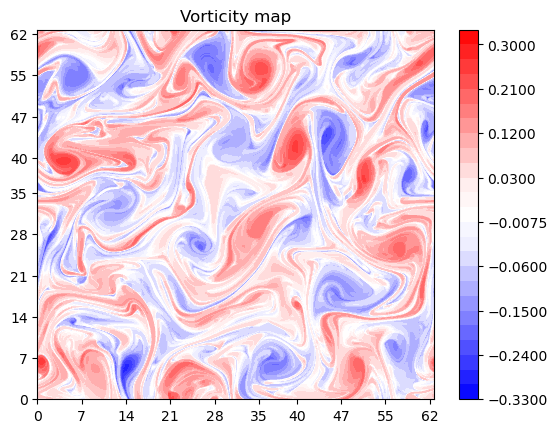

In [30]:
plot(data2[0,:,:],"Vorticity map")

## Using PyDMD

In [9]:
dmd = DMD(svd_rank=10,sorted_eigs='real') #very long too, took abt 8 mins for me
dmd.fit(Snapshots2)

Exception ignored in: <function tqdm.__del__ at 0x00000215688B14E0>
Traceback (most recent call last):
  File "c:\Users\Utilisateur\anaconda3\envs\py311\Lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "c:\Users\Utilisateur\anaconda3\envs\py311\Lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


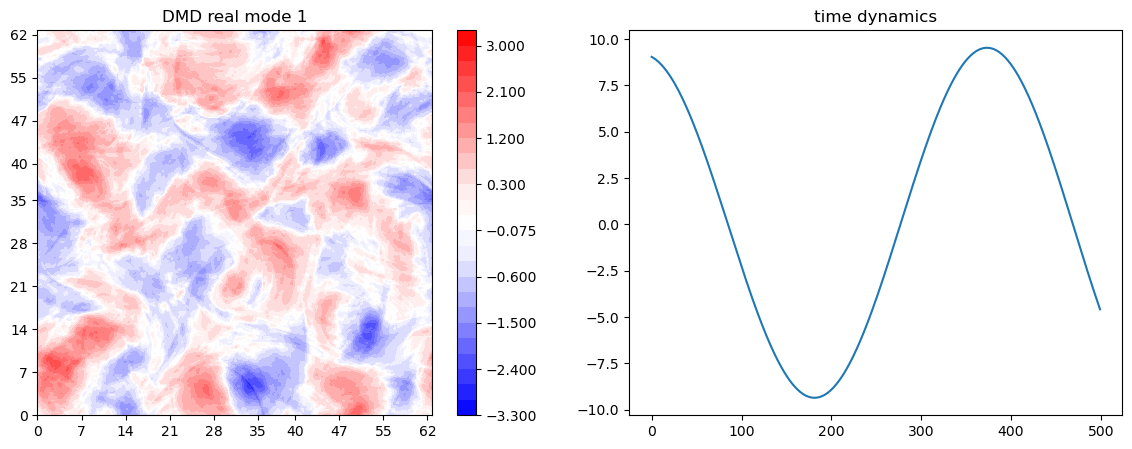

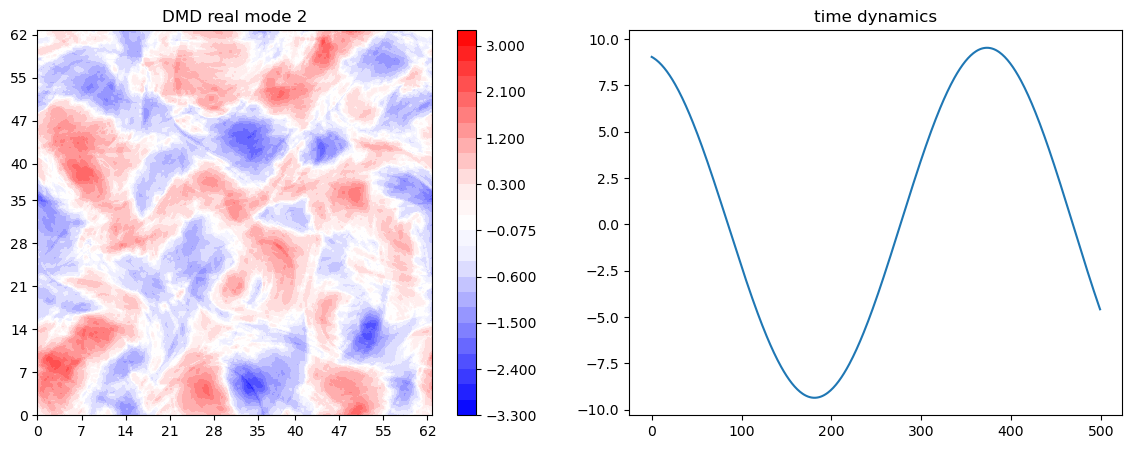

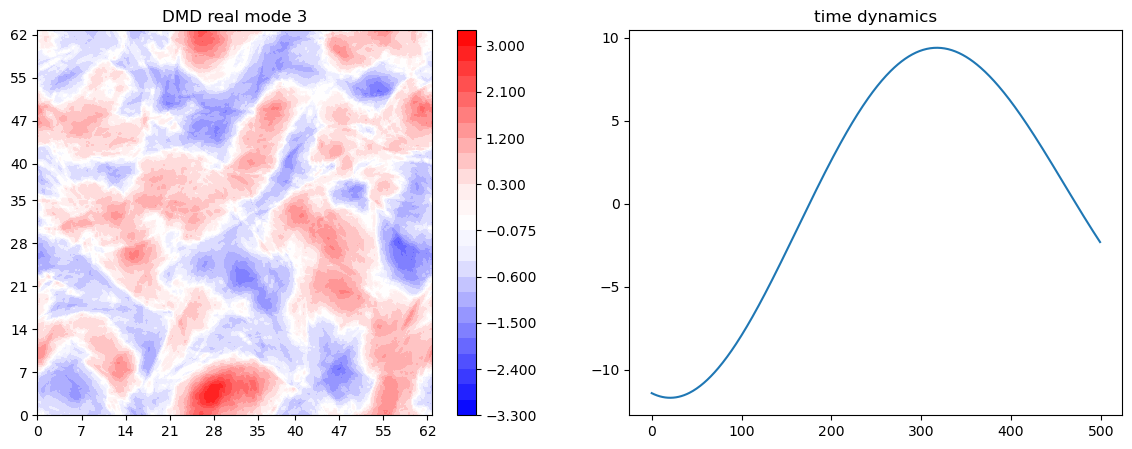

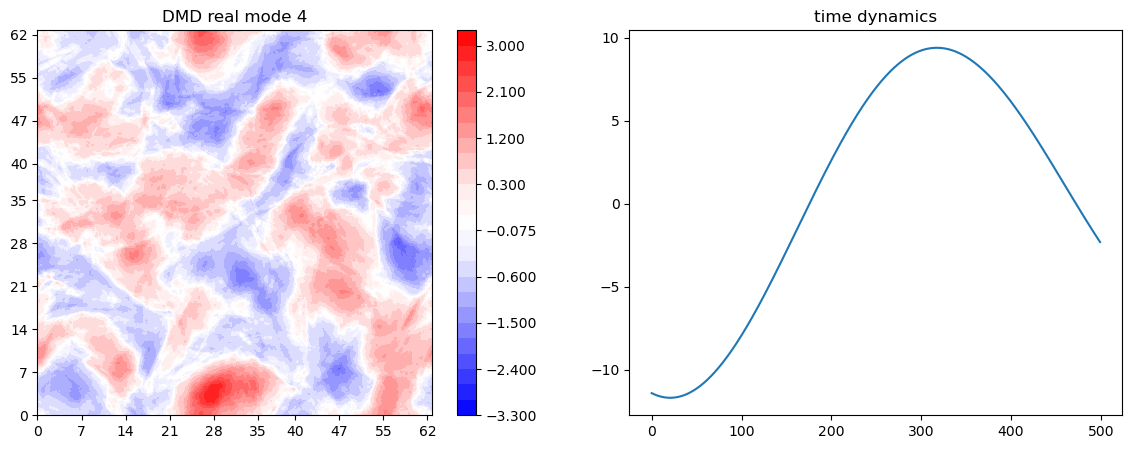

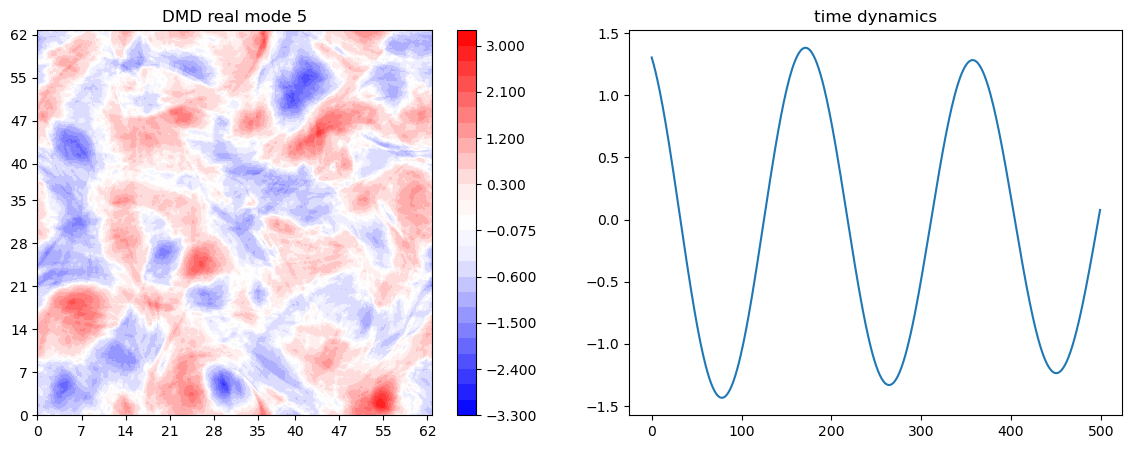

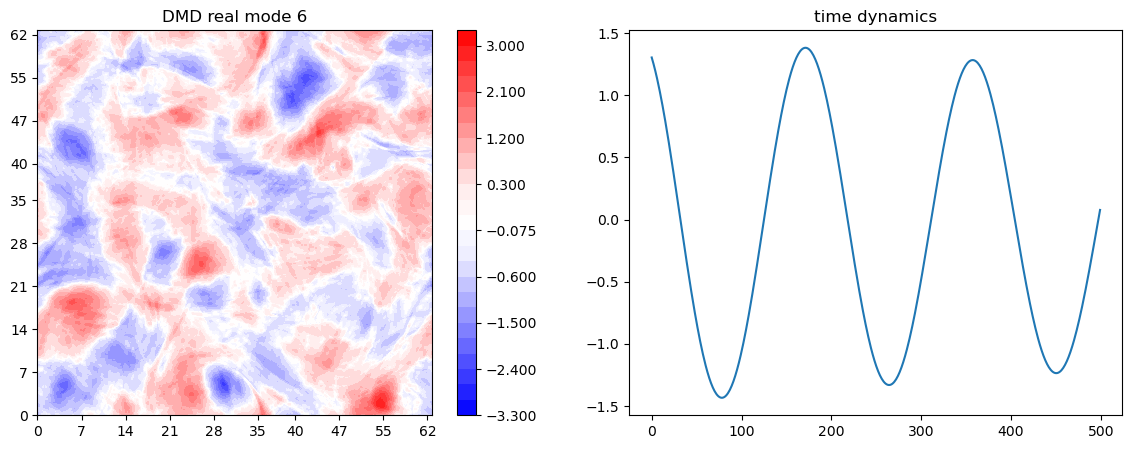

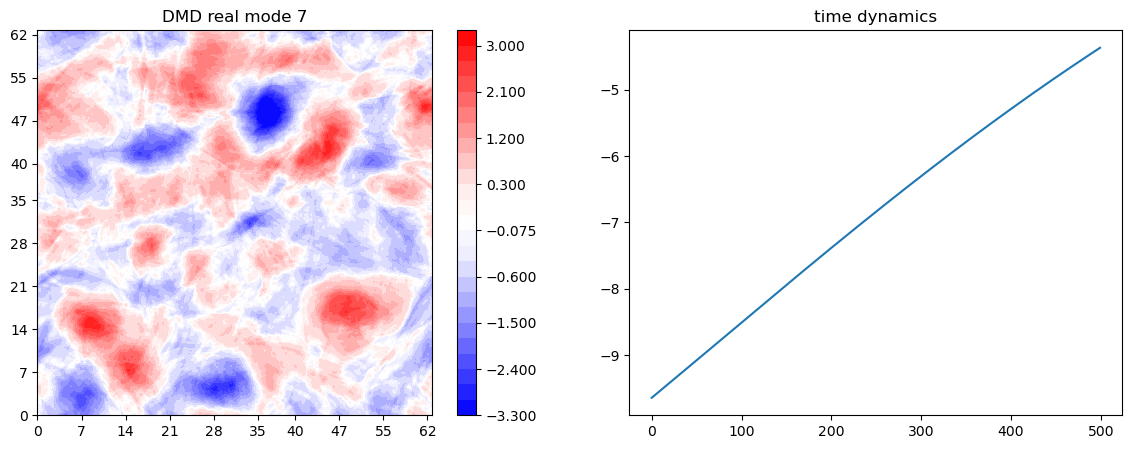

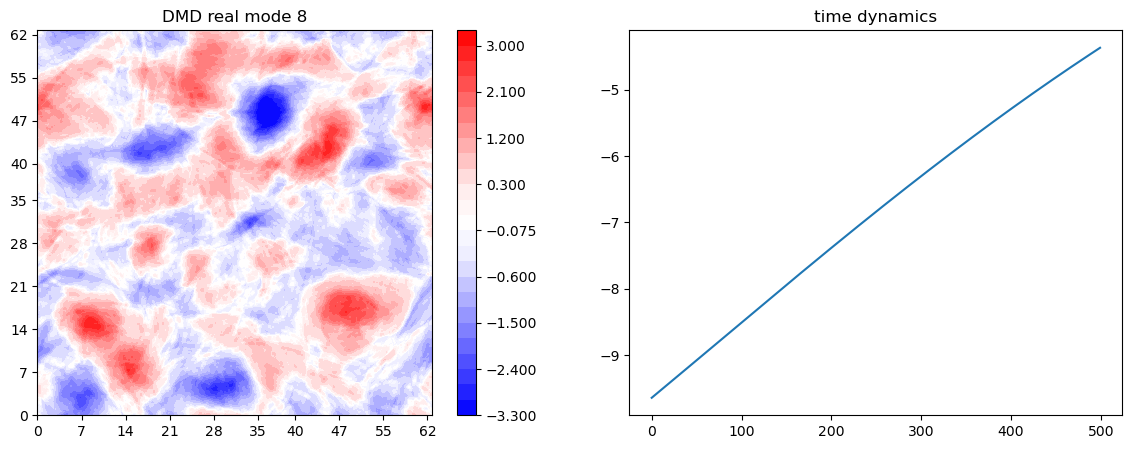

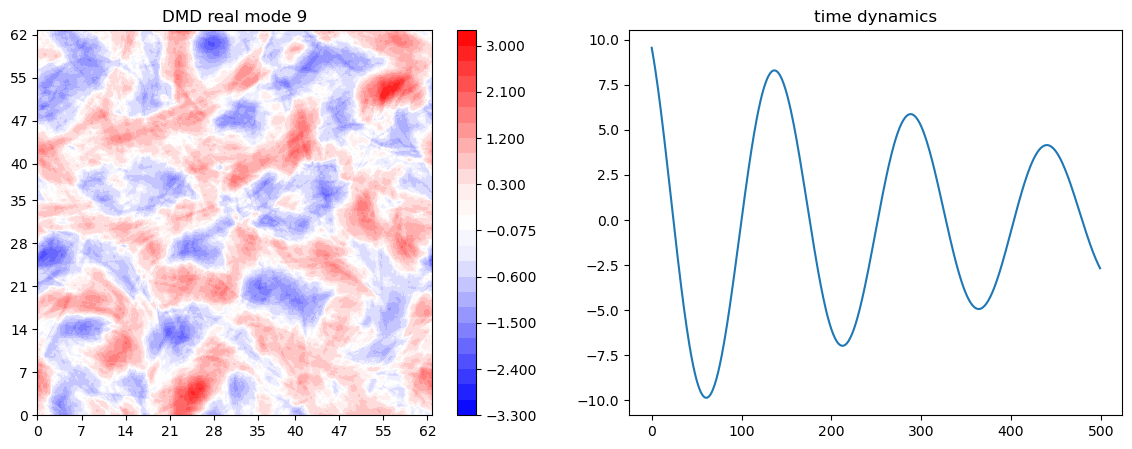

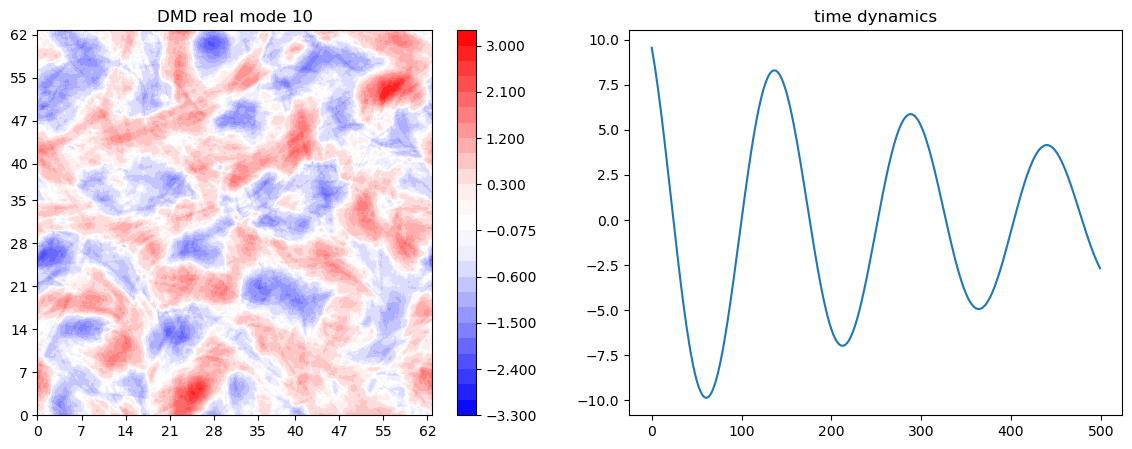

In [12]:
for i in range(10):
    h = dmd.modes[:,-(i+1)]
    d = dmd.dynamics[-(i+1),:]
    h=h/h.std()
    plot(np.real(h),f"DMD real mode {i+1}",'mode',d)

### Prediction

In [20]:
dmd_pred = DMD(svd_rank=10,sorted_eigs='real') #took abt 1min20 for me 
dmd_pred.fit(Snapshots2[:,:200])

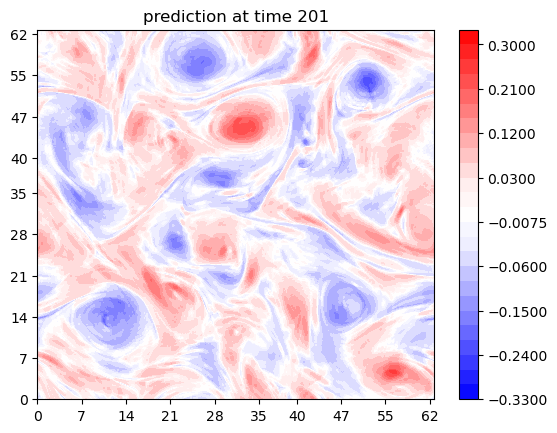

In [22]:
plot(dmd_pred.predict(Snapshots2[:,200]),"prediction at time 201",'vort')

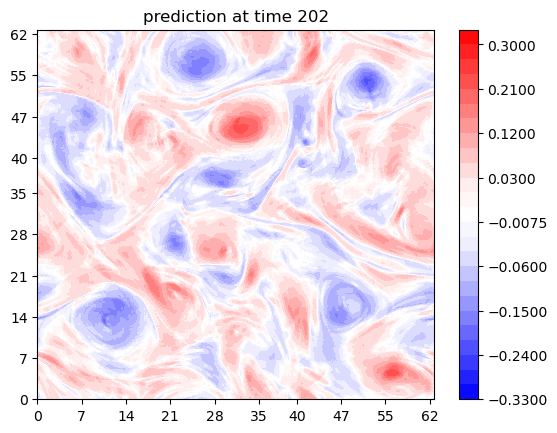

In [24]:
plot(dmd_pred.predict(Snapshots2[:,201]),"prediction at time 202",'vort')

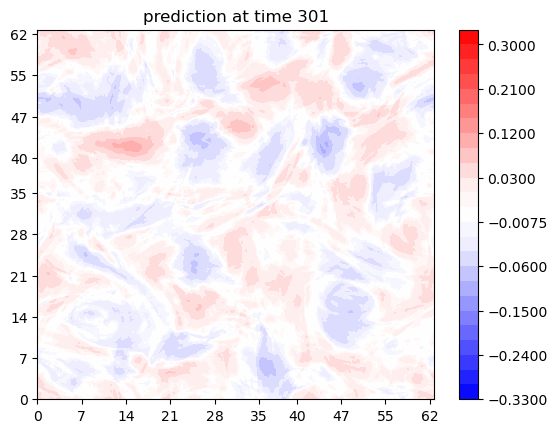

In [25]:
plot(dmd_pred.predict(Snapshots2[:,300]),"prediction at time 301",'vort')

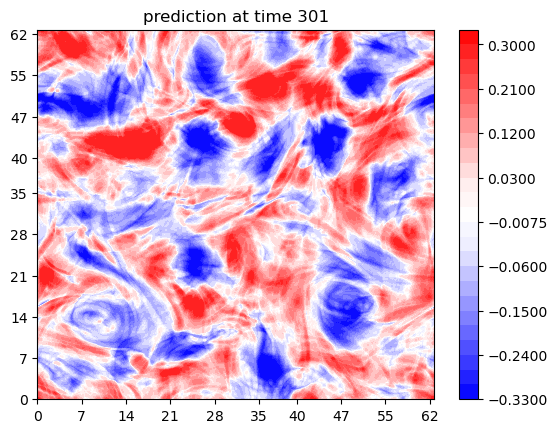

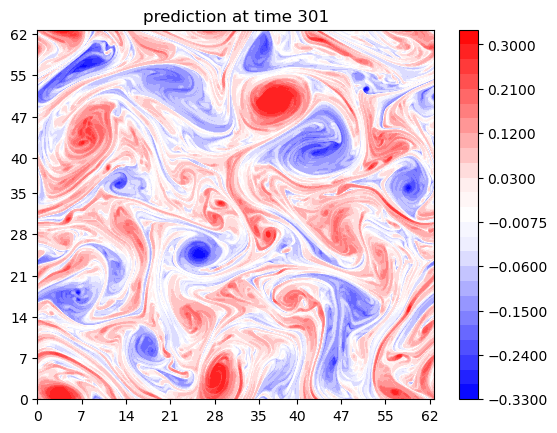

In [49]:
pred_301 = dmd_pred.predict(Snapshots2[:,300])
plot(pred_301/(pred_301.std())**0.5,"prediction at time 301",'vort')
plot(Snapshots2[:,301],"prediction at time 301",'vort')

## MATLAB code adaptation

In [27]:
U,S,V = np.linalg.svd(Snapshots2[:,:-1],full_matrices=False)

r=10
U=U[:,:r]
V=V[:r,:]
Smat=np.diag(S[:r])


A_tilde = U.T@Snapshots2[:,1:]@V.T@np.linalg.inv(Smat)
eigs,W = np.linalg.eig(A_tilde)

idx = eigs.argsort()[::-1]
W = W[:,idx]
eigs = eigs[idx]

Phi = Snapshots2[:,1:]@V.T@np.linalg.inv(Smat)@W

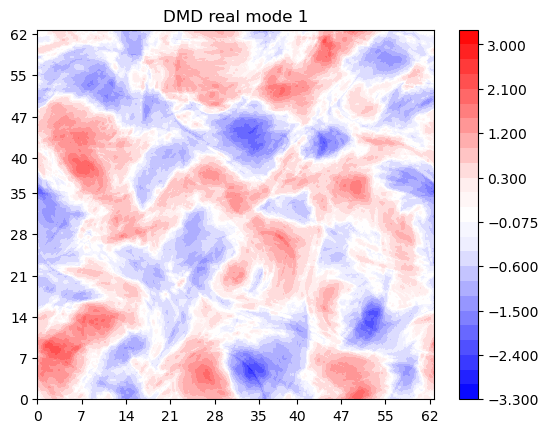

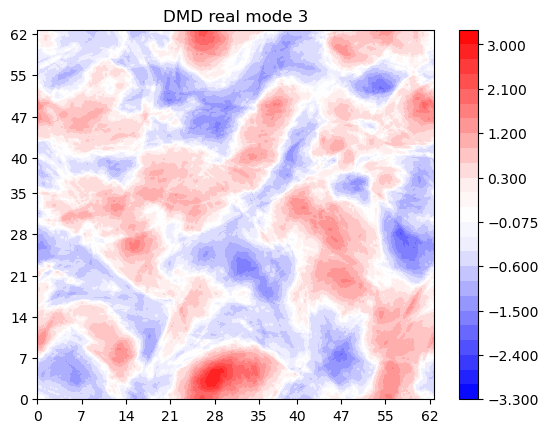

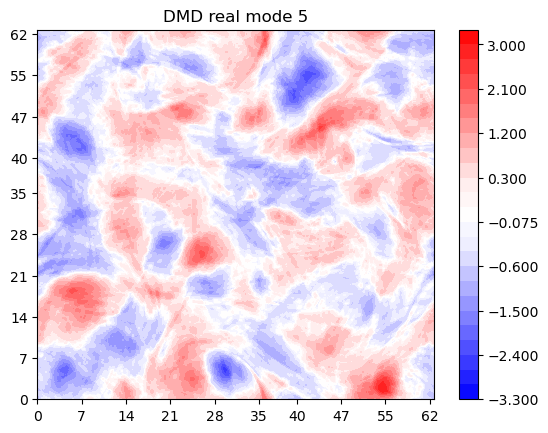

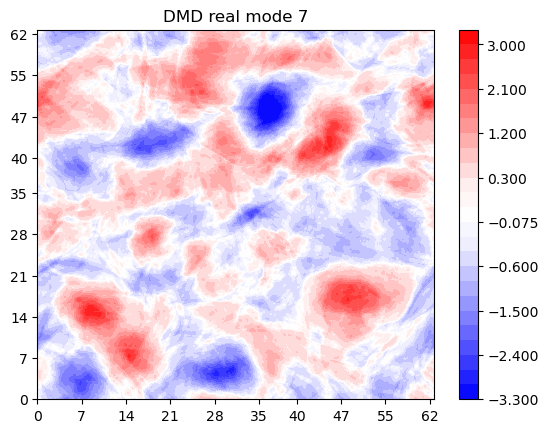

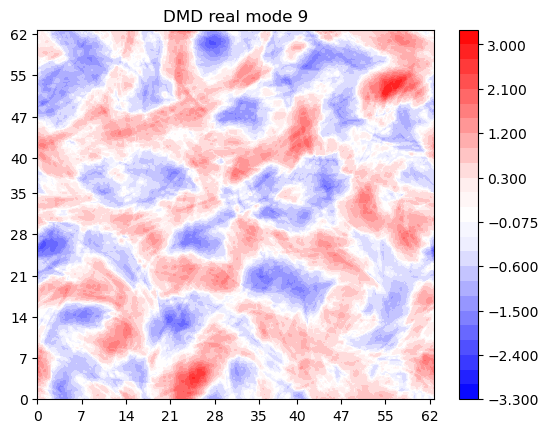

In [28]:
for i in range(0,10,2):
    h = Phi[:,i]
    h=h/h.std()
    plot(np.real(h),f"DMD real mode {i+1}",'sim','mode')